In [1]:
import tensorflow as tf 
# import tensorflow_io as tfio
import tensorflow_probability as tfp

print('Tensorflow Version:')
print(tf.__version__)
print()
print('Tensorflow-Probability Version:')
print(tfp.__version__)
print()
print('Listing all GPU resources:')
print(tf.config.experimental.list_physical_devices('GPU'))
print()

import tensorflow.keras as keras
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import os
from tqdm import trange
import sys
import git
import importlib

mpl.rcParams['image.cmap'] = 'coolwarm'

Tensorflow Version:
2.8.0

Tensorflow-Probability Version:
0.12.0

Listing all GPU resources:
[]



In [5]:
# LAYER_NAME = 'encoder_1a_v2'
LAYER_NAME = 'deterministic'

FILTERS = 32
DATA_SIZE = 60000
PRIOR_MU = 0
PRIOR_SIGMA = 10

BATCH_SIZE = 128
EPOCHS = 200
VERBOSE = 2

N_PREDICTIONS = 10

ROOT_PATH = git.Repo("", search_parent_directories=True).git.rev_parse("--show-toplevel")
DATA_PATH = ROOT_PATH + "/data/"
SMALL_DATA_PATH = ROOT_PATH + "/load_trained_models" + "/data_small/"
LAYER_PATH = ROOT_PATH + "/layers/" + LAYER_NAME + "/"
SAVE_PATH = LAYER_PATH + LAYER_NAME + "_bayesian_model.h5"
PICKLE_PATH = LAYER_PATH + LAYER_NAME + '_hist.pkl'
MODEL_PATH = LAYER_PATH + LAYER_NAME + "_model"
IMAGE_PATH = ROOT_PATH + "/images/" + LAYER_NAME + "/"

In [6]:
print("-" * 30)
print("Constructing model...")
print("-" * 30)
spec = importlib.util.spec_from_file_location(MODEL_PATH, MODEL_PATH + ".py")
ModelLoader = importlib.util.module_from_spec(spec)
spec.loader.exec_module(ModelLoader)
model = ModelLoader.make_model()
print(model.summary())

------------------------------
Constructing model...
------------------------------

Input size: (None, 144, 144, 4)
Output size: (None, 144, 144, 1)
Model: "model_deterministic"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 144, 144, 4  0           []                               
                                )]                                                                
                                                                                                  
 encoder_1_a (Conv2D)           (None, 144, 144, 32  1184        ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 encoder_1_b (Conv2D)        

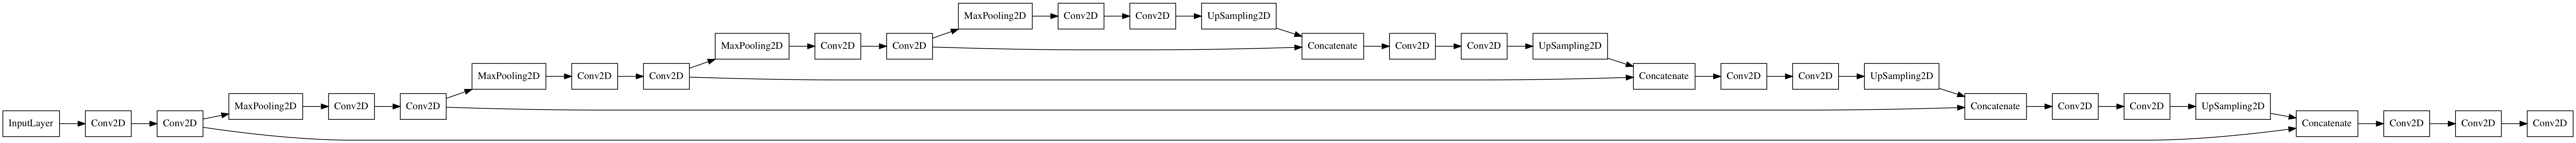

In [8]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_layer_names=False,
    rankdir="LR",
    expand_nested=False,
    dpi=200,
)

In [9]:
dot = tf.keras.utils.model_to_dot(
    model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    subgraph=False,
)

In [10]:
import pydot
pydot.Graph(dot)

In [12]:
model.load_weights(SAVE_PATH)
print("Model weights loaded successfully\n")

Model weights loaded successfully



In [13]:
n_test = 100
y_test = msks_test = np.load(SMALL_DATA_PATH + 'msks_test.npy')
imgs_test = np.load(SMALL_DATA_PATH + 'imgs_test.npy')

print("First " + str(n_test) + " test samples loaded\n")

First 100 test samples loaded



In [14]:
Xy_test = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(imgs_test),
                                tf.data.Dataset.from_tensor_slices(msks_test))
                             ).cache().batch(BATCH_SIZE).prefetch(8)

In [23]:
# prediction_size = list(msks_test.shape)
# prediction_size.insert(0, N_PREDICTIONS)
# prediction_test = np.zeros(prediction_size)
# print("Getting Monte Carlo samples of test predictions...")
# for i in trange(N_PREDICTIONS):
#     prediction_test[i] = model.predict(Xy_test)

In [30]:
model.run_eagerly

False

In [24]:
y_pred = model.fit(imgs_test, msks_test, batch_size=100)

2/2 [==============================] - 33s 15s/step - loss: 1376.8381 - likelihood_loss: 1376.8381 - mean_binary_crossentropy: 0.0229


In [25]:
tf.gradients(model(imgs_test), imgs_test)

RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.

In [31]:
var = model.trainable_variables
with tf.GradientTape() as tape:
    tape.watch(var)
    y_pred = model(imgs_test)

In [32]:
grad = tape.gradient(y_pred, var)

In [46]:
layer_names=['encoder_1_a',
'encoder_1_b',
'encoder_2_a',
'encoder_2_b',
'encoder_3_a',
'encoder_3_b',
'encoder_4_a',
'encoder_4_b',
'encoder_5_a',
'encoder_5_b',
'decoder_4_a',
'decoder_4_b',
'decoder_3_a',
'decoder_3_b',
'decoder_2_a',
'decoder_2_b',
'decoder_1_a',
'decoder_1_b',
'output_layer']

In [49]:
sum_sensitivity = []
mean_sensitivity = []

for layer_name, w_grad_, b_grad_ in zip(layer_names, grad[0::2], grad[1::2]):
    sum_sensitivity.append(abs(w_grad_.numpy().sum()+b_grad_.numpy().sum()))
    mean_sensitivity.append(abs(w_grad_.numpy().sum()+b_grad_.numpy().sum()) / (w_grad_.numpy().size + b_grad_.numpy().size))
    print(layer_name, sum_sensitivity[-1], mean_sensitivity[-1])

encoder_1_a 3326973.8 2809.944045608108
encoder_1_b 445944.3 48.220622026384085
encoder_2_a 1239065.8 66.9910115700692
encoder_2_b 7226.848 0.195701043775218
encoder_3_a 992601.1 13.439681610160312
encoder_3_b 168692.92 1.1430298804409693
encoder_4_a 768265.4 2.602807130176713
encoder_4_b 232268.3 0.39362170701430316
encoder_5_a 568720.6 0.4819012888082972
encoder_5_b 453561.75 0.19220281904290518
decoder_4_a 370275.78 0.20922750911439497
decoder_4_b 2269.683 0.0038463989721203057
decoder_3_a 105423.22 0.23824671578952125
decoder_3_b 38551.75 0.2612190345836947
decoder_2_a 16102.22 0.14551601112061252
decoder_2_b 545367.8 14.768409133990469
decoder_1_a 78506.96 2.8362341379154623
decoder_1_b 158814.69 17.172868458044984
output_layer 238356.6 7222.927083333333


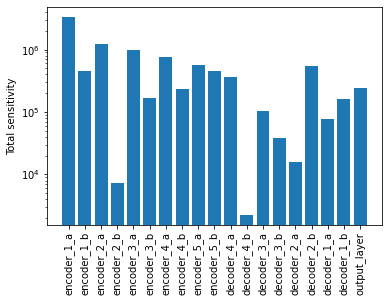

In [56]:
plt.bar(layer_names, sum_sensitivity)
plt.xticks(rotation='vertical')
plt.ylabel('Total sensitivity')
plt.yscale('log')
plt.show()

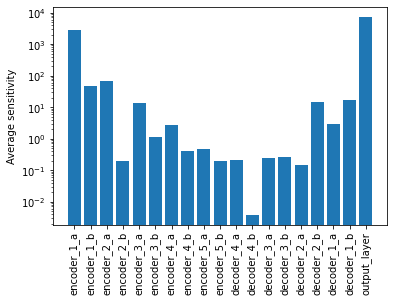

In [55]:
plt.bar(layer_names, mean_sensitivity)
plt.xticks(rotation='vertical')
plt.ylabel('Average sensitivity')
plt.yscale('log')
plt.show()

In [ ]:
for i in trange(0, 200, 20):
    
    plt.figure(dpi=200)
    plt.subplot(221)
    plt.title('Test Data T2-FLAIR')
    plt.imshow(imgs_test[i, :, :, 0], cmap='gray')

    plt.subplot(222)
    plt.title('Test Data T1')
    plt.imshow(imgs_test[i, :, :, 1], cmap='gray')

    plt.subplot(223)
    plt.title('Test Data T1-Contrast')
    plt.imshow(imgs_test[i, :, :, 2], cmap='gray')

    plt.subplot(224)
    plt.title('Test Data T2')
    plt.imshow(imgs_test[i, :, :, 3], cmap='gray')
    plt.tight_layout()
    plt.savefig(IMAGE_PATH +  'input_images_'+str(i).zfill(4)+'.png')

    
    plt.figure(dpi=200)

    plt.subplot(221)
    plt.title('\nPredicted Label Mean')
    plt.imshow(prediction_test.mean(0)[i, :, :, 0], interpolation='nearest')
    plt.colorbar()
    plt.clim(0, 1)

    plt.subplot(222)
    plt.title('\nPredicted Label Stddev')
    plt.imshow(prediction_test.std(0)[i, :, :, 0], interpolation='nearest')
    plt.clim(0, 0.2)
    plt.colorbar()

    plt.subplot(223)
    plt.title('True Label')
    plt.imshow(msks_test[i, :, :, 0], interpolation='nearest')
    plt.clim(0, 1)
    plt.colorbar()
    
    plt.subplot(224)
    plt.title('\nTruth-Prediction Discrepency')
    plt.imshow((msks_test[i, :, :, 0] - prediction_test.mean(0)[i, :, :, 0]), 
               interpolation='nearest')
    plt.clim(-1, 1)
    plt.colorbar()


    plt.tight_layout()

    plt.savefig(IMAGE_PATH + 'prediction_images_'+str(i).zfill(4)+'.png')


    plt.figure(dpi=200)

    plt.subplot(221)
    plt.title('\nPredicted Label 10th percentile')
    plt.imshow(np.percentile(prediction_test[:, i, :, :, 0], 10, axis=0), interpolation='nearest')
    plt.clim(0, 1)
    plt.colorbar()

    plt.subplot(222)
    plt.title('\nPredicted Label 50th percentile')
    plt.imshow(np.percentile(prediction_test[:, i, :, :, 0], 50, axis=0), interpolation='nearest')
    plt.clim(0, 1)
    plt.colorbar()

    plt.subplot(223)
    plt.title('Predicted Label 90th percentile')
    plt.imshow(np.percentile(prediction_test[:, i, :, :, 0], 90, axis=0), interpolation='nearest')
    plt.clim(0, 1)
    plt.colorbar()

    plt.subplot(224)
    plt.title('True Label')
    plt.imshow(msks_test[i, :, :, 0], interpolation='nearest')
    plt.clim(0, 1)
    plt.colorbar()

    plt.tight_layout()
    plt.savefig(IMAGE_PATH + 'prediction_percentile_images_' + str(i).zfill(4)+'.png')

In [ ]:
history = pickle.load(open(PICKLE_PATH, 'rb'))

In [ ]:
plt.figure(dpi=100)
plt.semilogy(history['loss'], label='training loss (ELBO)')
plt.semilogy(history['val_loss'], label='testing loss')
plt.legend()
# plt.savefig(IMAGE_PATH + 'training_history.png')

In [ ]:
LAYER_NAME = 'encoder_1a_v2'

FILTERS = 32
DATA_SIZE = 60000
PRIOR_MU = 0
PRIOR_SIGMA = 10

BATCH_SIZE = 128
EPOCHS = 200
VERBOSE = 2

N_PREDICTIONS = 100

ROOT_PATH = git.Repo("", search_parent_directories=True).git.rev_parse("--show-toplevel")
DATA_PATH = ROOT_PATH + "/data/"
SMALL_DATA_PATH = ROOT_PATH + "/load_trained_models" + "/data_small/"
LAYER_PATH = ROOT_PATH + "/layers/" + LAYER_NAME + "/"
SAVE_PATH = LAYER_PATH + LAYER_NAME + "_bayesian_model.h5"
PICKLE_PATH = LAYER_PATH + LAYER_NAME + '_hist.pkl'
MODEL_PATH = LAYER_PATH + LAYER_NAME + "_model"
IMAGE_PATH = ROOT_PATH + "/images/" + LAYER_NAME + "/"

In [ ]:
print("-" * 30)
print("Constructing model...")
print("-" * 30)
spec = importlib.util.spec_from_file_location(MODEL_PATH, MODEL_PATH + ".py")
ModelLoader = importlib.util.module_from_spec(spec)
spec.loader.exec_module(ModelLoader)
model_1a = ModelLoader.make_model()
print(model_1a.summary())

In [ ]:
model_1a.load_weights(SAVE_PATH)
print("Model weights loaded successfully\n")

In [ ]:
prediction_test_1a = np.zeros(prediction_size)
print("Getting Monte Carlo samples of test predictions...")
for i in trange(N_PREDICTIONS):
    prediction_test_1a[i] = model_1a.predict(Xy_test)

In [ ]:
history_1a = pickle.load(open(PICKLE_PATH, 'rb'))
plt.figure(dpi=100)
plt.semilogy(history_1a['loss'], label='training loss (ELBO)')
plt.semilogy(history_1a['val_loss'], label='testing loss')
plt.legend()
# plt.savefig(IMAGE_PATH + 'training_history.png')

In [ ]:
prediction_test.shape

In [ ]:
im = 200

p_bins =np.zeros((200, 144, 144, 10))
q_bins =np.zeros((200, 144, 144, 10))

for n in trange(0, 200):
    for i in range(144):
        for j in range(144):
            p_bins[n, i, j, :], _ = np.histogram(prediction_test[:, n, i, j, 0], 10, range=[0, 1], density=True)

    for i in range(144):
        for j in range(144):
            q_bins[n, i, j, :], _ = np.histogram(prediction_test_1a[:, n, i, j, 0], 10, range=[0, 1], density=True)

In [ ]:
kl = np.sum(p_bins * np.log((p_bins+1e-6) / (q_bins +1e-6)), axis=-1)
# kl = kl.mean(0)

In [ ]:
kl.shape

In [ ]:
plt.figure(dpi=200)
plt.subplot(131)
plt.imshow(kl[40])
# plt.title(str(k)
plt.colorbar()
# plt.show()

plt.subplot(132)
plt.title('all_layer')
plt.imshow(prediction_test.std(0)[40, :, :, 0], interpolation='nearest')
# plt.clim(0, 0.2)
# plt.colorbar()

plt.subplot(133)
plt.title('encoder_1a')
plt.imshow(prediction_test_1a.std(0)[40, :, :, 0], interpolation='nearest')
# plt.clim(0, 0.2)
# plt.colorbar()

In [ ]:
print(prediction_test[40, 0, 0].mean(), prediction_test[40, 0, 0].std())
print(prediction_test_1a[40, 0, 0].mean(), prediction_test_1a[40, 0, 0].std())


In [ ]:
plt.hist(prediction_test[40, 75, 115], 10, range=[0, 1], alpha=0.3, label='all_layers', density=True)
plt.hist(prediction_test_1a[40, 75, 115], 10, range=[0, 1], alpha=0.3, label='encoder_1a', density=True)
plt.legend()


kl_pixel = (p_bins[40, 75, 115]*np.log((p_bins[40, 75, 115]+1e-6) / (q_bins[40, 75, 115]+1e-6))).sum()

plt.title(str(kl_pixel))
plt.show()

# mse(pmf_1, pmf2)
# kl(pmf_1, pmf2)

In [ ]:
plt.hist(
    np.log(np.exp(model.get_weights()[1].flatten()) + 1)
)
plt.show()

In [ ]:
plt.hist(
    np.log(np.exp(model_1a.get_weights()[1].flatten()) + 1)
)
plt.show()

In [ ]:
for i in trange(0, 200, 20):
    
    plt.figure(dpi=200)
    plt.subplot(221)
    plt.title('Test Data T2-FLAIR')
    plt.imshow(imgs_test[i, :, :, 0], cmap='gray')

    plt.subplot(222)
    plt.title('Test Data T1')
    plt.imshow(imgs_test[i, :, :, 1], cmap='gray')

    plt.subplot(223)
    plt.title('Test Data T1-Contrast')
    plt.imshow(imgs_test[i, :, :, 2], cmap='gray')

    plt.subplot(224)
    plt.title('Test Data T2')
    plt.imshow(imgs_test[i, :, :, 3], cmap='gray')
    plt.tight_layout()
#     plt.savefig(IMAGE_PATH +  'input_images_'+str(i).zfill(4)+'.png')

    
    plt.figure(dpi=200)

    plt.subplot(221)
    plt.title('\nPredicted Label Mean')
    plt.imshow(prediction_test_1a.mean(0)[i, :, :, 0], interpolation='nearest')
    plt.colorbar()
    plt.clim(0, 1)

    plt.subplot(222)
    plt.title('\nPredicted Label Stddev')
    plt.imshow(prediction_test_1a.std(0)[i, :, :, 0], interpolation='nearest')
    plt.clim(0, 0.2)
    plt.colorbar()

    plt.subplot(223)
    plt.title('True Label')
    plt.imshow(msks_test[i, :, :, 0], interpolation='nearest')
    plt.clim(0, 1)
    plt.colorbar()
    
    plt.subplot(224)
    plt.title('\nTruth-Prediction Discrepency')
    plt.imshow((msks_test[i, :, :, 0] - prediction_test.mean(0)[i, :, :, 0]), 
               interpolation='nearest')
    plt.clim(-1, 1)
    plt.colorbar()


    plt.tight_layout()

#     plt.savefig(IMAGE_PATH + 'prediction_images_'+str(i).zfill(4)+'.png')


    plt.figure(dpi=200)

    plt.subplot(221)
    plt.title('\nPredicted Label 10th percentile')
    plt.imshow(np.percentile(prediction_test_1a[:, i, :, :, 0], 10, axis=0), interpolation='nearest')
    plt.clim(0, 1)
    plt.colorbar()

    plt.subplot(222)
    plt.title('\nPredicted Label 50th percentile')
    plt.imshow(np.percentile(prediction_test_1a[:, i, :, :, 0], 50, axis=0), interpolation='nearest')
    plt.clim(0, 1)
    plt.colorbar()

    plt.subplot(223)
    plt.title('Predicted Label 90th percentile')
    plt.imshow(np.percentile(prediction_test_1a[:, i, :, :, 0], 90, axis=0), interpolation='nearest')
    plt.clim(0, 1)
    plt.colorbar()

    plt.subplot(224)
    plt.title('True Label')
    plt.imshow(msks_test[i, :, :, 0], interpolation='nearest')
    plt.clim(0, 1)
    plt.colorbar()

    plt.tight_layout()
#     plt.savefig(IMAGE_PATH + 'prediction_percentile_images_' + str(i).zfill(4)+'.png')

In [ ]:
LAYER_NAME = 'all_layers'

FILTERS = 32
DATA_SIZE = 60000
PRIOR_MU = 0
PRIOR_SIGMA = 10

BATCH_SIZE = 128
EPOCHS = 200
VERBOSE = 2

N_PREDICTIONS = 100

ROOT_PATH = git.Repo("", search_parent_directories=True).git.rev_parse("--show-toplevel")
DATA_PATH = ROOT_PATH + "/data/"
SMALL_DATA_PATH = ROOT_PATH + "/load_trained_models" + "/data_small/"
LAYER_PATH = ROOT_PATH + "/layers/" + LAYER_NAME + "/"
SAVE_PATH = LAYER_PATH + LAYER_NAME + "_bayesian_model.h5"
PICKLE_PATH = LAYER_PATH + LAYER_NAME + '_hist.pkl'
MODEL_PATH = LAYER_PATH + LAYER_NAME + "_model"
IMAGE_PATH = ROOT_PATH + "/images/" + LAYER_NAME + "/"

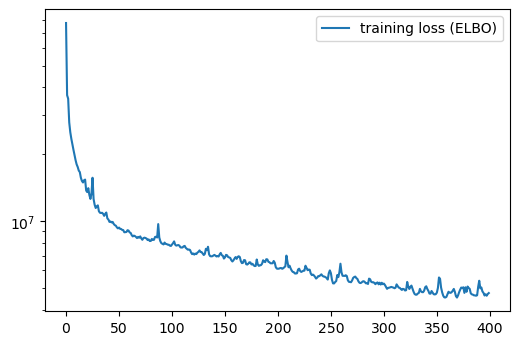

In [47]:
history_all = pickle.load(open(PICKLE_PATH, 'rb'))
plt.figure(dpi=100)
plt.semilogy(history_all['loss'][:800], label='training loss (ELBO)')
# plt.semilogy(history_all['val_loss'][:750], label='testing loss')
plt.legend()
# plt.savefig(IMAGE_PATH + 'training_history.png')

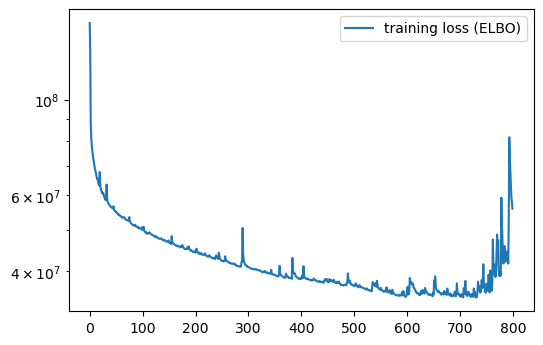

In [39]:
history_all = pickle.load(open(PICKLE_PATH, 'rb'))
plt.figure(dpi=100)
plt.semilogy(history_all['loss'][:800], label='training loss (ELBO)')
# plt.semilogy(history_all['val_loss'][:750], label='testing loss')
plt.legend()
# plt.savefig(IMAGE_PATH + 'training_history.png')

In [48]:
weights = model.get_weights()

In [49]:
mu = weights[0]
rho = weights[1]

In [50]:
sigma = np.log(1 + np.exp(rho))

In [54]:
np.log(1 + np.exp(-3))

0.04858735157374196

In [51]:
sigma.min()

0.0003765113

In [52]:
sigma.max()

0.0013429442

(array([ 95., 128., 197., 187., 185., 155., 124.,  57.,  22.,   2.]),
 array([0.00037651, 0.00047315, 0.0005698 , 0.00066644, 0.00076308,
        0.00085973, 0.00095637, 0.00105301, 0.00114966, 0.0012463 ,
        0.00134294], dtype=float32),
 <a list of 10 Patch objects>)

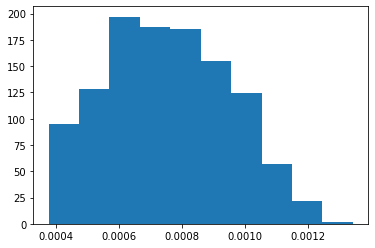

In [53]:
plt.hist(sigma.flatten())